In [74]:
#Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy
from multiprocessing import Pool
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [91]:
costs = np.load('../../Datasets/costs_parallelized.npz')
costs = costs['costs']
np.fill_diagonal(costs,0)

Movies = pd.read_csv('../../Datasets/Transformed.csv')
Movies = Movies.loc[Movies['vote_average'] > 0]

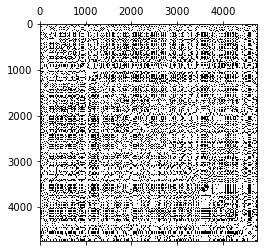

In [92]:
plt.spy(costs)
plt.show()

In [93]:
for i in range(Movies.loc[Movies['vote_average'] > 0].shape[0]):
    best_movie = np.argmax(costs[i])
    
    print('Original film: {} || Predicted movie: {}'.format(Movies.iloc[i]['title'],Movies.iloc[best_movie]['title']))

Original film: #Horror || Predicted movie: The Shawshank Redemption
Original film: (500) Days of Summer || Predicted movie: Seven Psychopaths
Original film: 10 Cloverfield Lane || Predicted movie: Pulp Fiction
Original film: 10 Days in a Madhouse || Predicted movie: The Departed
Original film: 10 Things I Hate About You || Predicted movie: Dancer, Texas Pop. 81
Original film: 102 Dalmatians || Predicted movie: Dancer, Texas Pop. 81
Original film: 10th & Wolf || Predicted movie: Batman Begins
Original film: 11:14 || Predicted movie: The Secret in Their Eyes
Original film: 12 Angry Men || Predicted movie: Dead Man Walking
Original film: 12 Rounds || Predicted movie: Dark Blue
Original film: 12 Years a Slave || Predicted movie: Django Unchained
Original film: 127 Hours || Predicted movie: The Great Escape
Original film: 13 Going on 30 || Predicted movie: Dancer, Texas Pop. 81
Original film: 13 Hours: The Secret Soldiers of Benghazi || Predicted movie: We Were Soldiers
Original film: 1408 

Original film: A Passage to India || Predicted movie: Veer-Zaara
Original film: A Perfect Getaway || Predicted movie: Eastern Promises
Original film: A Prairie Home Companion || Predicted movie: American History X
Original film: A Room for Romeo Brass || Predicted movie: Dead Poets Society
Original film: A Room with a View || Predicted movie: The Perks of Being a Wallflower
Original film: A Scanner Darkly || Predicted movie: Coraline
Original film: A Separation || Predicted movie: 12 Angry Men
Original film: A Serious Man || Predicted movie: Dancer, Texas Pop. 81
Original film: A Shine of Rainbows || Predicted movie: Anne of Green Gables
Original film: A Simple Plan || Predicted movie: American History X
Original film: A Simple Wish || Predicted movie: Harry Potter and the Prisoner of Azkaban
Original film: A Single Man || Predicted movie: The Help
Original film: A Sound of Thunder || Predicted movie: Pulp Fiction
Original film: A Streetcar Named Desire || Predicted movie: The Color Pu

Original film: Best in Show || Predicted movie: Little Big Top
Original film: Better Luck Tomorrow || Predicted movie: Se7en
Original film: Betty Fisher and Other Stories || Predicted movie: The Shawshank Redemption
Original film: Beverly Hills Chihuahua || Predicted movie: The Lego Movie
Original film: Beverly Hills Cop || Predicted movie: Beverly Hills Cop II
Original film: Beverly Hills Cop II || Predicted movie: Beverly Hills Cop
Original film: Beverly Hills Cop III || Predicted movie: Beverly Hills Cop II
Original film: Beyond Borders || Predicted movie: Apocalypse Now
Original film: Beyond the Black Rainbow || Predicted movie: Spirited Away
Original film: Beyond the Lights || Predicted movie: Me You and Five Bucks
Original film: Beyond the Mat || Predicted movie: Hoop Dreams
Original film: Beyond the Sea || Predicted movie: The Chorus
Original film: Beyond the Valley of the Dolls || Predicted movie: Dancer, Texas Pop. 81
Original film: Bicentennial Man || Predicted movie: Dancer,

Original film: C.H.U.D. || Predicted movie: Halloween
Original film: CJ7 || Predicted movie: Dancer, Texas Pop. 81
Original film: Ca$h || Predicted movie: Nine Queens
Original film: Cabin Fever || Predicted movie: Halloween
Original film: Caddyshack || Predicted movie: Dancer, Texas Pop. 81
Original film: Cadillac Records || Predicted movie: City of God
Original film: Call + Response || Predicted movie: Counting
Original film: Camping Sauvage || Predicted movie: The Shawshank Redemption
Original film: Can't Hardly Wait || Predicted movie: Jawbreaker
Original film: Can't Stop the Music || Predicted movie: Dancer, Texas Pop. 81
Original film: Cape Fear || Predicted movie: The Secret in Their Eyes
Original film: Capitalism: A Love Story || Predicted movie: Inside Job
Original film: Capote || Predicted movie: Freedom Writers
Original film: Capricorn One || Predicted movie: The Martian
Original film: Captain America: Civil War || Predicted movie: Thor
Original film: Captain America: The Fir

Original film: Daddy's Home || Predicted movie: Dancer, Texas Pop. 81
Original film: Dallas Buyers Club || Predicted movie: Straight Outta Compton
Original film: Damnation Alley || Predicted movie: The Bourne Ultimatum
Original film: Damsels in Distress || Predicted movie: Pitch Perfect
Original film: Dance Flick || Predicted movie: Seven Samurai
Original film: Dancer in the Dark || Predicted movie: One Flew Over the Cuckoo's Nest
Original film: Dancer, Texas Pop. 81 || Predicted movie: Little Big Top
Original film: Dances with Wolves || Predicted movie: The Great Escape
Original film: Dancin' It's On || Predicted movie: Black Swan
Original film: Dangerous Liaisons || Predicted movie: Cruel Intentions
Original film: Danny Collins || Predicted movie: Dancer, Texas Pop. 81
Original film: Dante's Peak || Predicted movie: Die Hard
Original film: Dark Blue || Predicted movie: Training Day
Original film: Dark City || Predicted movie: Memento
Original film: Dark Shadows || Predicted movie: Da

Original film: Down in the Valley || Predicted movie: Submarine
Original film: Down to Earth || Predicted movie: Spirited Away
Original film: Down to You || Predicted movie: Dancer, Texas Pop. 81
Original film: Downfall || Predicted movie: Judgment at Nuremberg
Original film: Dr. Dolittle 2 || Predicted movie: Dancer, Texas Pop. 81
Original film: Dr. No || Predicted movie: The Spy Who Loved Me
Original film: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb || Predicted movie: The Lives of Others
Original film: Dracula || Predicted movie: Me You and Five Bucks
Original film: Dracula 2000 || Predicted movie: Pulp Fiction
Original film: Dracula Untold || Predicted movie: Interview with the Vampire
Original film: Dracula: Pages from a Virgin's Diary || Predicted movie: Halloween
Original film: Draft Day || Predicted movie: The Blind Side
Original film: Drag Me to Hell || Predicted movie: Halloween
Original film: Dragon Blade || Predicted movie: Seven Samurai
Original fi

Original film: Fish Tank || Predicted movie: Notes on a Scandal
Original film: Fiza || Predicted movie: Anne of Green Gables
Original film: Flags of Our Fathers || Predicted movie: The Boy in the Striped Pyjamas
Original film: Flame & Citron || Predicted movie: Reservoir Dogs
Original film: Flash Gordon || Predicted movie: Dawn of the Planet of the Apes
Original film: Flash of Genius || Predicted movie: Schindler's List
Original film: Flashdance || Predicted movie: Dancer in the Dark
Original film: Flatliners || Predicted movie: Once Upon a Time in America
Original film: Flawless || Predicted movie: Little Big Top
Original film: Fled || Predicted movie: 2 Guns
Original film: Flicka || Predicted movie: The Shawshank Redemption
Original film: Flight || Predicted movie: Saving Private Ryan
Original film: Flight of the Intruder || Predicted movie: Gladiator
Original film: Flight of the Phoenix || Predicted movie: Seven Samurai
Original film: Flightplan || Predicted movie: Pulp Fiction
Orig

Original film: Glengarry Glen Ross || Predicted movie: Cure
Original film: Glitter || Predicted movie: Amadeus
Original film: Glory || Predicted movie: Gettysburg
Original film: Glory Road || Predicted movie: Coach Carter
Original film: Go || Predicted movie: The Wolf of Wall Street
Original film: Go for It! || Predicted movie: City of God
Original film: Goal!: The Dream Begins || Predicted movie: Unbroken
Original film: God's Not Dead 2 || Predicted movie: The Visual Bible: The Gospel of John
Original film: Goddess of Love || Predicted movie: Memento
Original film: Gods and Generals || Predicted movie: Casablanca
Original film: Gods and Monsters || Predicted movie: Schindler's List
Original film: Gods of Egypt || Predicted movie: How to Train Your Dragon 2
Original film: Godsend || Predicted movie: Waltz with Bashir
Original film: Godzilla 2000 || Predicted movie: The Prisoner of Zenda
Original film: Going the Distance || Predicted movie: Fast Times at Ridgemont High
Original film: Go

Original film: Holy Motors || Predicted movie: The Shawshank Redemption
Original film: Home || Predicted movie: How to Train Your Dragon
Original film: Home Alone || Predicted movie: Dancer, Texas Pop. 81
Original film: Home Alone 2: Lost in New York || Predicted movie: Dancer, Texas Pop. 81
Original film: Home Fries || Predicted movie: Things We Lost in the Fire
Original film: Home Run || Predicted movie: Good Will Hunting
Original film: Home for the Holidays || Predicted movie: Dancer, Texas Pop. 81
Original film: Home on the Range || Predicted movie: WALL·E
Original film: Homefront || Predicted movie: Das Boot
Original film: Honey || Predicted movie: Me You and Five Bucks
Original film: Hoodwinked Too! Hood VS. Evil || Predicted movie: Dancer, Texas Pop. 81
Original film: Hoodwinked! || Predicted movie: WALL·E
Original film: Hook || Predicted movie: Interstellar
Original film: Hoop Dreams || Predicted movie: The Other Dream Team
Original film: Hoot || Predicted movie: If I Stay
Orig

Original film: In Good Company || Predicted movie: Dancer, Texas Pop. 81
Original film: In Her Line of Fire || Predicted movie: One Flew Over the Cuckoo's Nest
Original film: In Time || Predicted movie: Mad Max: Fury Road
Original film: In Too Deep || Predicted movie: The Shawshank Redemption
Original film: In the Bedroom || Predicted movie: Ordet
Original film: In the Company of Men || Predicted movie: Little Big Top
Original film: In the Cut || Predicted movie: Eyes Wide Shut
Original film: In the Heart of the Sea || Predicted movie: Airlift
Original film: In the Land of Blood and Honey || Predicted movie: Hotel Rwanda
Original film: In the Land of Women || Predicted movie: The Fault in Our Stars
Original film: In the Name of the King III || Predicted movie: Seven Samurai
Original film: In the Name of the King: A Dungeon Siege Tale || Predicted movie: The Prisoner of Zenda
Original film: In the Shadow of the Moon || Predicted movie: Counting
Original film: In the Valley of Elah || Pr

Original film: Keeping Up with the Steins || Predicted movie: Little Big Top
Original film: Keeping the Faith || Predicted movie: Dancer, Texas Pop. 81
Original film: Kevin Hart: Laugh at My Pain || Predicted movie: Dancer, Texas Pop. 81
Original film: Kevin Hart: Let Me Explain || Predicted movie: Dancer, Texas Pop. 81
Original film: Khiladi 786 || Predicted movie: Seven Samurai
Original film: Khumba || Predicted movie: Frozen
Original film: Kick-Ass || Predicted movie: The Dark Knight Rises
Original film: Kick-Ass 2 || Predicted movie: Captain America: The Winter Soldier
Original film: Kickboxer: Vengeance || Predicted movie: The Matrix
Original film: Kicking & Screaming || Predicted movie: Me You and Five Bucks
Original film: Kicks || Predicted movie: The Prisoner of Zenda
Original film: Kids || Predicted movie: City of God
Original film: Kill Bill: Vol. 1 || Predicted movie: Seven Samurai
Original film: Kill Bill: Vol. 2 || Predicted movie: Guardians of the Galaxy
Original film: Ki

Original film: Mary Reilly || Predicted movie: 12 Years a Slave
Original film: Masked and Anonymous || Predicted movie: Hustle & Flow
Original film: Master and Commander: The Far Side of the World || Predicted movie: The Prisoner of Zenda
Original film: Match Point || Predicted movie: Days of Heaven
Original film: Maurice || Predicted movie: American Beauty
Original film: Max || Predicted movie: Interstellar
Original film: Max Keeble's Big Move || Predicted movie: Dancer, Texas Pop. 81
Original film: Max Payne || Predicted movie: Guardians of the Galaxy
Original film: Maximum Risk || Predicted movie: The Boondock Saints
Original film: May || Predicted movie: GoodFellas
Original film: Maze Runner: The Scorch Trials || Predicted movie: The Maze Runner
Original film: McFarland, USA || Predicted movie: Me Before You
Original film: Me Before You || Predicted movie: It's a Wonderful Life
Original film: Me You and Five Bucks || Predicted movie: Dreaming of Joseph Lees
Original film: Me and Or

Original film: No Good Deed || Predicted movie: Nightcrawler
Original film: No Man's Land: The Rise of Reeker || Predicted movie: The Dead Zone
Original film: No Reservations || Predicted movie: Stiff Upper Lips
Original film: No Strings Attached || Predicted movie: Dancer, Texas Pop. 81
Original film: Noah || Predicted movie: The Visual Bible: The Gospel of John
Original film: Nomad: The Warrior || Predicted movie: Seven Samurai
Original film: Non-Stop || Predicted movie: Captain Phillips
Original film: North Country || Predicted movie: Heavenly Creatures
Original film: Northfork || Predicted movie: Spirited Away
Original film: Not Another Teen Movie || Predicted movie: DodgeBall: A True Underdog Story
Original film: Not Cool || Predicted movie: Fast Times at Ridgemont High
Original film: Not Easily Broken || Predicted movie: The Shawshank Redemption
Original film: Notes on a Scandal || Predicted movie: Heavenly Creatures
Original film: Nothing || Predicted movie: Little Big Top
Origi

Original film: Quigley Down Under || Predicted movie: Me You and Five Bucks
Original film: Quills || Predicted movie: The Help
Original film: Quinceañera || Predicted movie: The Shawshank Redemption
Original film: Quo Vadis || Predicted movie: Barry Lyndon
Original film: R.I.P.D. || Predicted movie: DragonHeart
Original film: R.L. Stine's Monsterville: The Cabinet of Souls || Predicted movie: Dancer, Texas Pop. 81
Original film: R100 || Predicted movie: Dancer, Texas Pop. 81
Original film: RED || Predicted movie: Tombstone
Original film: RED 2 || Predicted movie: From Russia with Love
Original film: Rabbit Hole || Predicted movie: Days of Heaven
Original film: Rabbit-Proof Fence || Predicted movie: Mad Max 2: The Road Warrior
Original film: Race || Predicted movie: Soul Surfer
Original film: Race to Witch Mountain || Predicted movie: The Fifth Element
Original film: Rachel Getting Married || Predicted movie: Fish Tank
Original film: Racing Stripes || Predicted movie: Dancer, Texas Pop.

Original film: Saving Silverman || Predicted movie: Dancer, Texas Pop. 81
Original film: Savva. Heart of the Warrior || Predicted movie: How to Train Your Dragon
Original film: Saw || Predicted movie: The Shining
Original film: Saw II || Predicted movie: Halloween
Original film: Saw III || Predicted movie: Halloween
Original film: Saw IV || Predicted movie: Halloween
Original film: Saw V || Predicted movie: Evil Dead II
Original film: Saw VI || Predicted movie: The Shining
Original film: Saw: The Final Chapter || Predicted movie: Evil Dead II
Original film: Say It Isn't So || Predicted movie: Dancer, Texas Pop. 81
Original film: Scarface || Predicted movie: True Romance
Original film: Scary Movie 2 || Predicted movie: Dancer, Texas Pop. 81
Original film: Scary Movie 3 || Predicted movie: Dancer, Texas Pop. 81
Original film: Scary Movie 4 || Predicted movie: Dancer, Texas Pop. 81
Original film: Scary Movie 5 || Predicted movie: Dancer, Texas Pop. 81
Original film: Schindler's List || Pr

Original film: Snow Falling on Cedars || Predicted movie: Blood Diamond
Original film: Snow Flower and the Secret Fan || Predicted movie: Inside Out
Original film: Snow White and the Huntsman || Predicted movie: Harry Potter and the Prisoner of Azkaban
Original film: Snow White and the Seven Dwarfs || Predicted movie: Spirited Away
Original film: Snow White: A Deadly Summer || Predicted movie: The Shining
Original film: Snow White: A Tale of Terror || Predicted movie: Army of Darkness
Original film: Snowpiercer || Predicted movie: Dredd
Original film: Solaris || Predicted movie: The Right Stuff
Original film: Soldier || Predicted movie: The Matrix
Original film: Solitary Man || Predicted movie: Dancer, Texas Pop. 81
Original film: Solomon and Sheba || Predicted movie: Waltz with Bashir
Original film: Some Guy Who Kills People || Predicted movie: Dancer, Texas Pop. 81
Original film: Some Like It Hot || Predicted movie: Dancer, Texas Pop. 81
Original film: Someone Like You... || Predicte

Original film: The 13th Warrior || Predicted movie: The Lord of the Rings: The Two Towers
Original film: The 33 || Predicted movie: Apollo 13
Original film: The 40 Year Old Virgin || Predicted movie: Dancer, Texas Pop. 81
Original film: The 41–Year–Old Virgin Who Knocked Up Sarah Marshall and Felt Superbad About It || Predicted movie: Dancer, Texas Pop. 81
Original film: The 51st State || Predicted movie: Pulp Fiction
Original film: The 5th Quarter || Predicted movie: Remember the Titans
Original film: The 5th Wave || Predicted movie: The Hunger Games: Catching Fire
Original film: The 6th Day || Predicted movie: Moon
Original film: The Abyss || Predicted movie: 20,000 Leagues Under the Sea
Original film: The Act of Killing || Predicted movie: Inside Job
Original film: The Addams Family || Predicted movie: Interview with the Vampire
Original film: The Adjustment Bureau || Predicted movie: Moon
Original film: The Adventurer: The Curse of the Midas Box || Predicted movie: The Green Mile
O

Original film: The Crazies || Predicted movie: Memento
Original film: The Crew || Predicted movie: Seven Samurai
Original film: The Crime of Padre Amaro || Predicted movie: Spotlight
Original film: The Crocodile Hunter: Collision Course || Predicted movie: Karachi se Lahore
Original film: The Croods || Predicted movie: Pirates of the Caribbean: The Curse of the Black Pearl
Original film: The Crow || Predicted movie: Spirited Away
Original film: The Cry of the Owl || Predicted movie: Rebecca
Original film: The Crying Game || Predicted movie: Me You and Five Bucks
Original film: The Curious Case of Benjamin Button || Predicted movie: Spirited Away
Original film: The Curse of Downers Grove || Predicted movie: Eastern Promises
Original film: The Curse of the Jade Scorpion || Predicted movie: Little Big Top
Original film: The Curse of the Were-Rabbit || Predicted movie: The Hunger Games: Catching Fire
Original film: The DUFF || Predicted movie: The Fault in Our Stars
Original film: The Da V

Original film: The Host || Predicted movie: The Host
Original film: The Host || Predicted movie: The Host
Original film: The Host || Predicted movie: The Host
Original film: The Host || Predicted movie: The Host
Original film: The Hotel New Hampshire || Predicted movie: Fast Times at Ridgemont High
Original film: The Hours || Predicted movie: Dead Poets Society
Original film: The House Bunny || Predicted movie: Me You and Five Bucks
Original film: The House of Mirth || Predicted movie: The Shawshank Redemption
Original film: The House of Sand || Predicted movie: The Second Mother
Original film: The House of the Devil || Predicted movie: Memento
Original film: The Howling || Predicted movie: Spellbound
Original film: The Hudsucker Proxy || Predicted movie: Dancer, Texas Pop. 81
Original film: The Hunchback of Notre Dame || Predicted movie: Anne of Green Gables
Original film: The Hundred-Foot Journey || Predicted movie: American History X
Original film: The Hunger Games || Predicted movi

Original film: The Libertine || Predicted movie: Trainspotting
Original film: The Life Aquatic with Steve Zissou || Predicted movie: Pirates of the Caribbean: At World's End
Original film: The Life Before Her Eyes || Predicted movie: Mulholland Drive
Original film: The Life of David Gale || Predicted movie: Dead Man Walking
Original film: The Limey || Predicted movie: Beverly Hills Cop
Original film: The Lincoln Lawyer || Predicted movie: Hot Fuzz
Original film: The Lion King || Predicted movie: Karachi se Lahore
Original film: The Lion of Judah || Predicted movie: The Prisoner of Zenda
Original film: The Little Ponderosa Zoo || Predicted movie: #Horror
Original film: The Little Prince || Predicted movie: Bridge to Terabithia
Original film: The Little Vampire || Predicted movie: Willy Wonka & the Chocolate Factory
Original film: The Lives of Others || Predicted movie: Network
Original film: The Living Daylights || Predicted movie: From Russia with Love
Original film: The Living Wake ||

Original film: The Protector || Predicted movie: The Proposition
Original film: The Puffy Chair || Predicted movie: The Shawshank Redemption
Original film: The Punisher || Predicted movie: Guardians of the Galaxy
Original film: The Purge || Predicted movie: Blade Runner
Original film: The Purge: Anarchy || Predicted movie: Eden Lake
Original film: The Purge: Election Year || Predicted movie: The Matrix
Original film: The Pursuit of D.B. Cooper || Predicted movie: The Prisoner of Zenda
Original film: The Pursuit of Happyness || Predicted movie: Metropolis
Original film: The Queen || Predicted movie: The King's Speech
Original film: The Quick and the Dead || Predicted movie: Face/Off
Original film: The Quiet || Predicted movie: The Savages
Original film: The Quiet American || Predicted movie: Before Sunset
Original film: The R.M. || Predicted movie: Dancer, Texas Pop. 81
Original film: The Rage: Carrie 2 || Predicted movie: Halloween
Original film: The Raid || Predicted movie: Seven Samu

Original film: The Theory of Everything || Predicted movie: Schindler's List
Original film: The Thief and the Cobbler || Predicted movie: Harry Potter and the Order of the Phoenix
Original film: The Thin Red Line || Predicted movie: Platoon
Original film: The Thing || Predicted movie: Alien
Original film: The Thirteenth Floor || Predicted movie: Mulholland Drive
Original film: The Thomas Crown Affair || Predicted movie: Woman in Gold
Original film: The Three Burials of Melquiades Estrada || Predicted movie: Lawrence of Arabia
Original film: The Three Musketeers || Predicted movie: Big Hero 6
Original film: The Three Stooges || Predicted movie: Dancer, Texas Pop. 81
Original film: The Tigger Movie || Predicted movie: Winnie the Pooh
Original film: The Timber || Predicted movie: The Prisoner of Zenda
Original film: The Time Machine || Predicted movie: Moon
Original film: The Time Traveler's Wife || Predicted movie: Notes on a Scandal
Original film: The To Do List || Predicted movie: Danc

Original film: Videodrome || Predicted movie: Alien
Original film: Virgin Territory || Predicted movie: The Prisoner of Zenda
Original film: Virtuosity || Predicted movie: The Matrix
Original film: Volcano || Predicted movie: Blade Runner
Original film: Volver || Predicted movie: Dancer, Texas Pop. 81
Original film: W. || Predicted movie: American History X
Original film: WALL·E || Predicted movie: Persepolis
Original film: Wag the Dog || Predicted movie: Mr. Smith Goes to Washington
Original film: Wah-Wah || Predicted movie: The Geographer Drank His Globe Away
Original film: Waiting for Guffman || Predicted movie: The Business of Fancydancing
Original film: Waiting... || Predicted movie: Dancer, Texas Pop. 81
Original film: Waitress || Predicted movie: Dancer, Texas Pop. 81
Original film: Waking Ned || Predicted movie: Little Big Top
Original film: Wal-Mart: The High Cost of Low Price || Predicted movie: Capitalism: A Love Story
Original film: Walk Hard: The Dewey Cox Story || Predict

Original film: Young Sherlock Holmes || Predicted movie: Sherlock Holmes
Original film: Your Highness || Predicted movie: Dancer, Texas Pop. 81
Original film: Your Sister's Sister || Predicted movie: August Rush
Original film: Yours, Mine and Ours || Predicted movie: Dancer, Texas Pop. 81
Original film: Youth in Revolt || Predicted movie: The Martian
Original film: Z Storm || Predicted movie: Se7en
Original film: ZMD: Zombies of Mass Destruction || Predicted movie: The Shining
Original film: Zack and Miri Make a Porno || Predicted movie: Dancer, Texas Pop. 81
Original film: Zambezia || Predicted movie: Dancer, Texas Pop. 81
Original film: Zathura: A Space Adventure || Predicted movie: Karachi se Lahore
Original film: Zero Dark Thirty || Predicted movie: The Kingdom
Original film: Zero Effect || Predicted movie: Little Big Top
Original film: Zipper || Predicted movie: American Psycho
Original film: Zodiac || Predicted movie: Se7en
Original film: Zombie Hunter || Predicted movie: Dancer,

In [94]:
G = nx.DiGraph()
for i in range(Movies.loc[Movies['vote_average'] > 0].shape[0]):
    G.add_node(i)
    G.add_edge(i,np.argmax(costs[i]))

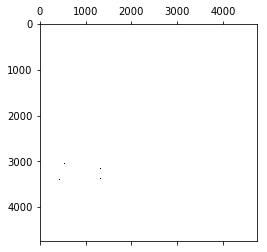

In [79]:
G_adj = nx.adjacency_matrix(G)
G_adj = G_adj.todense()
plt.spy(G_adj)
plt.show()

In [80]:
degree_distribution=sorted(nx.degree(G).values(),reverse=True) # degree distribution sorted from highest to lowest
degree_distribution

[432,
 73,
 71,
 44,
 43,
 37,
 37,
 35,
 32,
 30,
 24,
 24,
 24,
 23,
 21,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,